# Netflix - Movies and Shows Analysis

### Objectives

**Descriptive analysis**: the idea of this notebook is just understand and analyze the data provided by the dataset explained below. Thus, we can understand the patterns and trending of movies/tv-shows that netflix add to their catalogue.

### Dataset summary

##### **Main Dataset**: [Netflix Movies and TV Shows](https://www.kaggle.com/shivamb/netflix-shows)
    
TV Shows and Movies listed on Netflix
This dataset consists of tv shows and movies available on Netflix as of 2019. The dataset is collected from Flixable which is a third-party Netflix search engine.

In 2018, they released an interesting report which shows that the number of TV shows on Netflix has nearly tripled since 2010. The streaming service’s number of movies has decreased by more than 2,000 titles since 2010, while its number of TV shows has nearly tripled. It will be interesting to explore what all other insights can be obtained from the same dataset.

12 columns:
- show_id (string): unique identifier for each movie
- type (string): TV Show or Movie
- title (string): title of the record
- director (string): director of the record
- cast (string): principal actors
- country (string): country where was filmed
- date_added (date): date added to netflix
- release_year (int): year of release
- rating (string): rating audience
- duration (string): duration of the record
- listed_in (string): tags of description
- description (string): description of the record



[//]: # "Cell intentionally left in blank"



In [1]:
# import basic packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
from collections import OrderedDict

from sklearn.preprocessing import StandardScaler

In [2]:
df = pd.read_csv("datasets/netflix_titles.csv")
df.shape

(7787, 12)

In [3]:
df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,TV Show,3%,NaN,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,"August 14, 2020",2020,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...
1,s2,Movie,7:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,"December 23, 2016",2016,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...
2,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,"December 20, 2018",2011,R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow..."
3,s4,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly...",United States,"November 16, 2017",2009,PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi..."
4,s5,Movie,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...",United States,"January 1, 2020",2008,PG-13,123 min,Dramas,A brilliant group of students become card-coun...


## Normalizing data

To avoid silly mistakes, I'm gonna normalize and standarize the actual data. The first step is convert each column to their respective data type. Because if we see the differents dtypes around the dataset, we can notice that are all object type except the year column. The idea is transform dates into date type

In [4]:
df.dtypes

show_id         object
type            object
title           object
director        object
cast            object
country         object
date_added      object
release_year     int64
rating          object
duration        object
listed_in       object
description     object
dtype: object

In [5]:
df["date_added"] = pd.to_datetime(df.date_added)
df.dtypes

show_id                 object
type                    object
title                   object
director                object
cast                    object
country                 object
date_added      datetime64[ns]
release_year             int64
rating                  object
duration                object
listed_in               object
description             object
dtype: object

Now let's check the missing data, which has NaN values

In [6]:
df.isna().any()

show_id         False
type            False
title           False
director         True
cast             True
country          True
date_added       True
release_year    False
rating           True
duration        False
listed_in       False
description     False
dtype: bool

### Getting dummies

There are a lot of categorical variables, so to handle them, get the dummy data from them is a good approach

#### Type dummies: TV Show or Movie

In [7]:
type_dummies = pd.get_dummies(df["type"])
df = pd.concat([df, type_dummies], axis=1)
df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,Movie,TV Show
0,s1,TV Show,3%,NaN,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,2020-08-14,2020,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...,0,1
1,s2,Movie,7:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,2016-12-23,2016,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...,1,0
2,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,2018-12-20,2011,R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow...",1,0
3,s4,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly...",United States,2017-11-16,2009,PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi...",1,0
4,s5,Movie,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...",United States,2020-01-01,2008,PG-13,123 min,Dramas,A brilliant group of students become card-coun...,1,0


#### Getting the listed_in dummies

Here we have to do a little more of work because the actual tags are all in a single string, so we have to separate them and create the dummies

In [8]:
def get_types_of_listed_in(x):
    # basic formatting to standarize the data
    x = x.lower()
    x = x.split(",")
    x = ["-".join(a.strip().split(" ")) for a in x]
    
    return x
            
for idx, listed_in in zip(df.index.values, df["listed_in"]):
    listed_in_formatted = get_types_of_listed_in(listed_in)
    
    for lis in listed_in_formatted:
        # add each type of 'listed in' as column, if it exists, set to one in the respective index
        # otherwise, create that column and set all the values to 0, except the current index
        if lis in df.columns.values:
            df.at[idx, lis] = 1
        else:
            df[lis] = 0
            df.at[idx, lis] = 1


Let's check if the previous computing was all right. To achieve that, we can watch the values in 'listed_in' in the first row, and it respectives dummies

In [9]:
print("Listed_id of the first row in the dataset " + df.loc[0, "listed_in"])
print("\n")
print("The dummies:: ")
pd.DataFrame(df.loc[0, "international-tv-shows": ]).T

Listed_id of the first row in the dataset International TV Shows, TV Dramas, TV Sci-Fi & Fantasy


The dummies:: 


,international-tv-shows,tv-dramas,tv-sci-fi-&-fantasy,dramas,international-movies,horror-movies,action-&-adventure,independent-movies,sci-fi-&-fantasy,tv-mysteries,...,tv-shows,classic-movies,cult-movies,tv-horror,stand-up-comedy-&-talk-shows,teen-tv-shows,stand-up-comedy,anime-features,tv-thrillers,classic-&-cult-tv
0,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


##### Getting the year when the show was added to Netflix and removing NaN values

In [10]:
df["year_added"]  = df["date_added"].apply(lambda x: x.year)

### Understanding the "type" variable

First, let's see the count of types of shows

In [11]:
df[["Movie", "TV Show"]].sum()

Movie      5377
TV Show    2410
dtype: int64

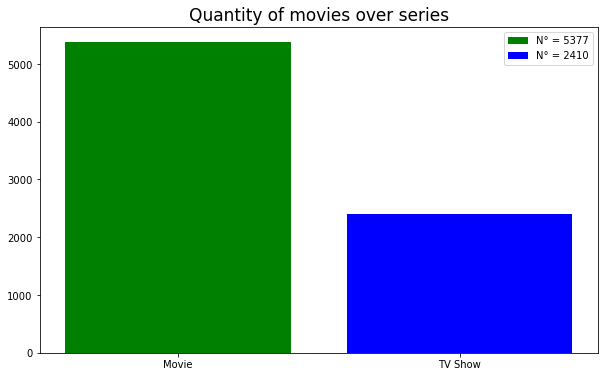

In [12]:
all_movies_and_shows = df[["Movie", "TV Show"]].sum()
fig, ax = plt.subplots(1, figsize=(10,6))
ax.bar(height=all_movies_and_shows["Movie"], x=["Movie"], color=['green'], label="N° = {}".format(all_movies_and_shows["Movie"]))
ax.bar(height=all_movies_and_shows["TV Show"], x=["TV Show"], color=['blue'], label="N° = {}".format(all_movies_and_shows["TV Show"]))
ax.set_title("Quantity of movies over series", fontsize=17)
ax.legend()

As we can see, there has been more movies than series

Let's see the growth of movies and TV Shows added to netflix over the years. 

ALERT SPOILER: In 2021 we will see a significant decrease, but it's because today is just february of 2021

Text(0.5, 1.0, 'Shows & Movies added to netflix over the years')

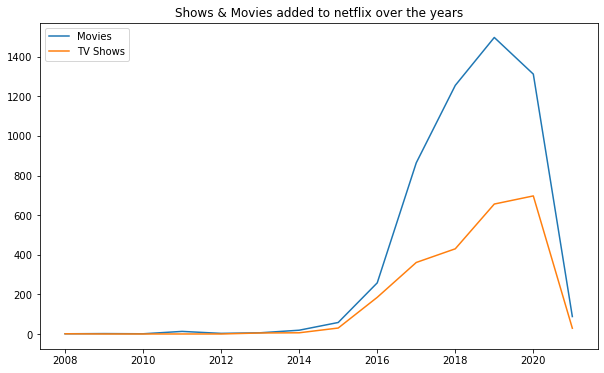

In [13]:
types_over_years = df[["Movie", "TV Show", "year_added"]].groupby("year_added").sum()
fig, ax = plt.subplots(1, figsize=(10,6))
ax.plot(types_over_years["Movie"], label="Movies")
ax.plot(types_over_years["TV Show"], label="TV Shows")
ax.legend()
plt.title("Shows & Movies added to netflix over the years")

The above chart tell us that the "explosion" of netflix, where more movies & shows were added starts in 2016, and still growing until today.
However, we can notice that from 2019 to 2020, there was a decrease in shows added.

Text(0.5, 1.0, 'Shows & Movies added to netflix over the years (2008 - 2020)')

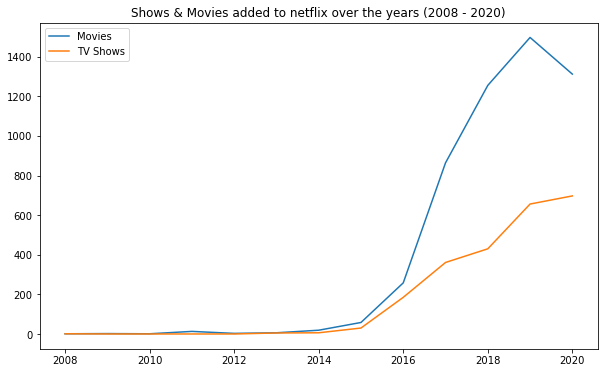

In [14]:
types_over_years_until_2020 = df[df["year_added"]<2021][["Movie", "TV Show", "year_added"]].groupby("year_added").sum()
fig, ax = plt.subplots(1, figsize=(10,6))
ax.plot(types_over_years_until_2020["Movie"], label="Movies")
ax.plot(types_over_years_until_2020["TV Show"], label="TV Shows")
ax.legend()
plt.title("Shows & Movies added to netflix over the years (2008 - 2020)")

## Getting useful information of the type of the show

First, we are gonna separate types dummies into a new dataframe with the respective year added to netflix

In [15]:
types_dummies = df.loc[:, "international-tv-shows":]
cols = types_dummies.columns.tolist()
cols = cols[-1:] + cols[:-1]
types_dummies = types_dummies[cols]
types_dummies.head()

,year_added,international-tv-shows,tv-dramas,tv-sci-fi-&-fantasy,dramas,international-movies,horror-movies,action-&-adventure,independent-movies,sci-fi-&-fantasy,...,tv-shows,classic-movies,cult-movies,tv-horror,stand-up-comedy-&-talk-shows,teen-tv-shows,stand-up-comedy,anime-features,tv-thrillers,classic-&-cult-tv
0,2020.0,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2016.0,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2018.0,0,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2017.0,0,0,0,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
4,2020.0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Now, with the purpose of see the different distribution of types around the years, let's group the dataframe by the year_added variable

In [16]:
types_dummies_ordered = types_dummies.groupby("year_added").sum()
types_dummies_ordered.index = types_dummies_ordered.index.astype(int)
types_dummies_ordered

,international-tv-shows,tv-dramas,tv-sci-fi-&-fantasy,dramas,international-movies,horror-movies,action-&-adventure,independent-movies,sci-fi-&-fantasy,tv-mysteries,...,tv-shows,classic-movies,cult-movies,tv-horror,stand-up-comedy-&-talk-shows,teen-tv-shows,stand-up-comedy,anime-features,tv-thrillers,classic-&-cult-tv
year_added,,,,,,,,,,,,,,,,,,,,,
2008,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
2009,0,0,0,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2010,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2011,0,0,0,13,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2012,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2013,1,4,1,0,0,0,0,0,0,1,...,0,0,0,0,1,1,4,0,1,0
2014,0,3,0,0,2,0,1,0,2,0,...,0,0,0,0,0,0,4,0,1,1
2015,3,9,2,12,10,2,2,7,2,2,...,0,0,0,2,0,1,13,0,1,1
2016,91,45,3,67,85,8,20,32,7,5,...,2,2,2,5,1,3,39,6,5,1


### Comparing the last three years

To watch the trendings, we are gonna focus in the last three years

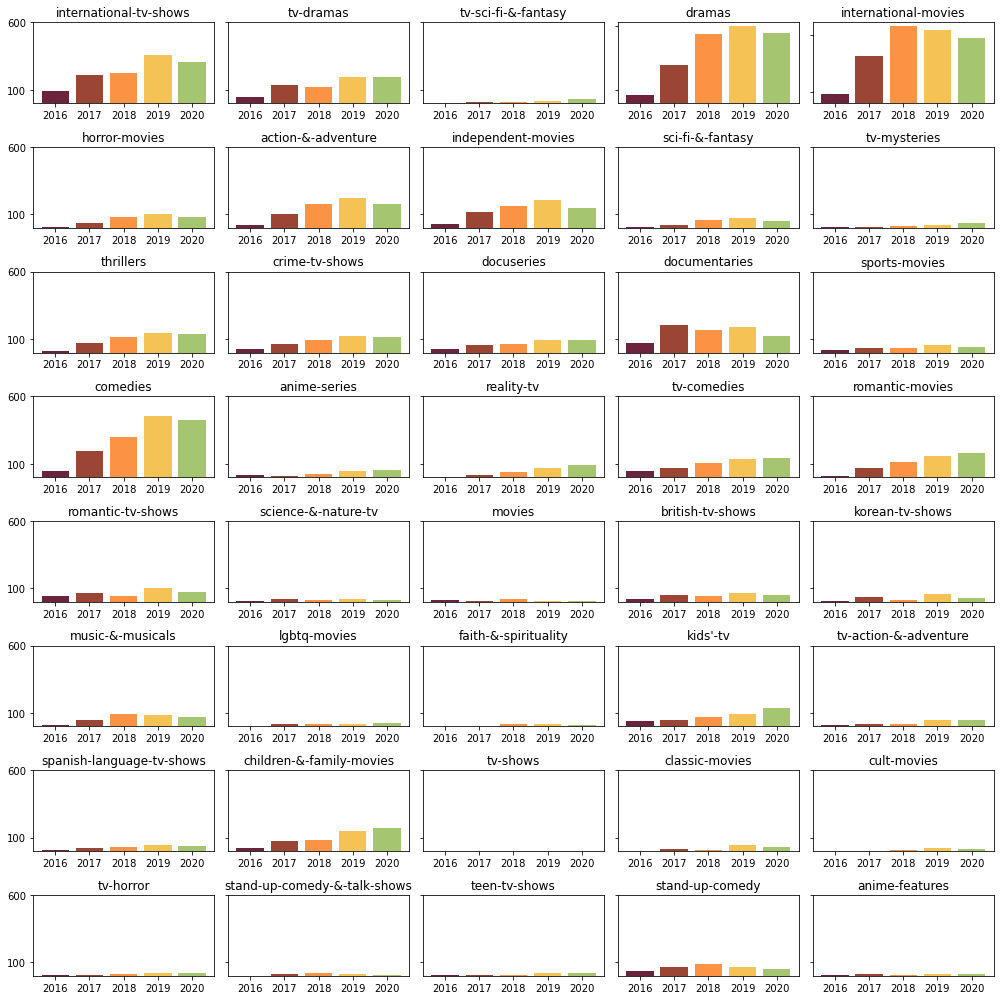

In [17]:
last_five_years = [2016, 2017, 2018, 2019, 2020]
types_dummies_last_five_years = types_dummies_ordered.loc[last_five_years]
cols = types_dummies_last_five_years.columns
n_cols_plot = 5
left_cols = [i for i in range(0, len(cols), n_cols_plot)]
colors = ["#6A243B", "#9B4634", "#FA9344", "#F5C256", "#A5C571"]

plt.rcParams["figure.figsize"] = (14,14)
fig, axes = plt.subplots(len(cols) // n_cols_plot, n_cols_plot)
for col, ax, i in zip(cols, axes.flat, range(len(cols))):
    ax.bar(height=types_dummies_last_five_years[col], 
           x=types_dummies_last_five_years.index,
           color=colors
          )
    ax.set_title(col)
    ax.set_xticks(types_dummies_last_five_years.index.values)
    ax.set_yticks([100, 600])
    
    if i not in left_cols:
        plt.setp(ax.get_yticklabels(), visible=False)
fig.tight_layout()

As we can see above, types like comedies, dramas, international movies and another ones, are the types that have been added the most in the last few years. So first we are gonna focus in analyze them 

Text(0.5, 0, 'Year')

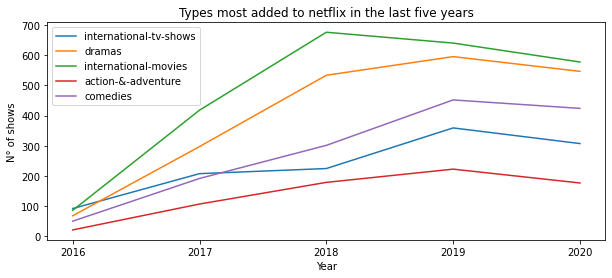

In [18]:
types_most_added = ["international-tv-shows", "dramas", "international-movies", "action-&-adventure", "comedies"]
plt.rcParams["figure.figsize"] = (10,4)
fig, ax = plt.subplots(1)
for ty in types_most_added:
    ax.plot(types_dummies_last_five_years.reset_index()["year_added"], types_dummies_last_five_years[ty], label=ty)
ax.set_xticks(last_five_years)
ax.legend()
ax.set_title("Types most added to netflix in the last five years")
ax.set_ylabel("N° of shows")
ax.set_xlabel("Year")

Getting the month when the show was added to Netflix. This is useful to in a future make comparisons with the two first months of this year (2021)

In [19]:
df["month_added"] = df["date_added"].apply(lambda x: x.month)

Now, we are gonna to analyze by the type of show. If it is a TV Show or if it is a Movie

In [20]:
columns_w_most_added = ["type", "rating", "duration", "date_added", "release_year", "year_added", "month_added"] + types_most_added
df_movies = df[df["type"] == "Movie"][columns_w_most_added].reset_index(drop=True)
df_tv_show = df[df["type"] == "TV Show"][columns_w_most_added].reset_index(drop=True)
df_movies.shape, df_tv_show.shape

((5377, 12), (2410, 12))

Parsing duration for movies dataframe (convert it to a int value)

In [21]:
df_movies["duration_min"] = df_movies["duration"].apply(lambda x: int(x.split(" ")[0]))
df_movies.head(2)

,type,rating,duration,date_added,release_year,year_added,month_added,international-tv-shows,dramas,international-movies,action-&-adventure,comedies,duration_min
0,Movie,TV-MA,93 min,2016-12-23,2016,2016.0,12.0,0,1,1,0,0,93
1,Movie,R,78 min,2018-12-20,2011,2018.0,12.0,0,0,1,0,0,78


Let's inspect the duration distributions of the movies

Text(0.5, 1.0, 'Movies duration distribution (in minutes)')

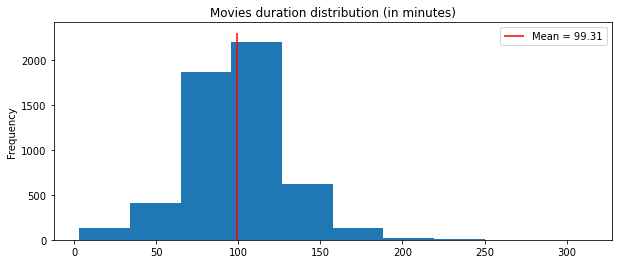

In [22]:
df_movies["duration_min"].plot(kind="hist", label="")
plt.vlines(x=df_movies["duration_min"].mean(), ymin=0, ymax=2300, colors=["red"], label="Mean = {}".format(np.round(df_movies["duration_min"].mean(), 2)))
plt.legend()
plt.title("Movies duration distribution (in minutes)")

As we can see, we notice a normal distribution with a bell shape form. A little right skew is seen. It says that are some movies that are larger than the duration mean (99.31 mins). Also, there are some right-outliers, meaning that are movies which their duration is so long (around 300 minutes). 

We can understand better the distribution visualizing it in a boxplot

Text(0.5, 1.0, 'Movies duration distribution (in minutes)')

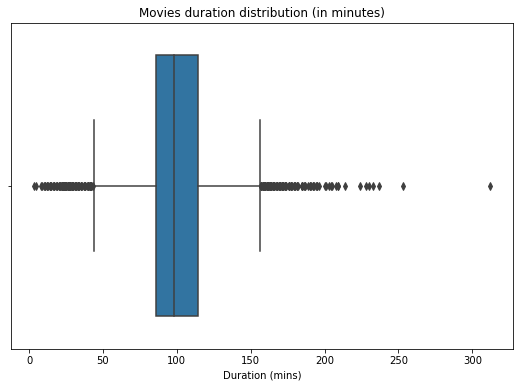

In [23]:
plt.figure(figsize=(9,6))
sns.boxplot(x=df_movies["duration_min"])
plt.xlabel("Duration (mins)")
plt.title("Movies duration distribution (in minutes)")

With the above boxplot, we can see that are movies which the duration of them is almost 0 minutes, and others which are more than 300 minutes. But the majority of the movies fall in the range of aprox (50 - 150) mins of duration.

In [24]:
print("The movie shorter in minutes has a length of {}".format(min(df_movies["duration_min"])))
print("And the longer movie is {} minutes".format(max(df_movies["duration_min"])))

The movie shorter in minutes has a length of 3
And the longer movie is 312 minutes


### Question to answer

Is there any pattern where specific type of movies are added in a specific month?

In [25]:
df_movies["month_addedx"] = df_movies["date_added"].apply(lambda x: x.month_name())
movies_groupped = df_movies[np.logical_and(df_movies["year_added"]>=2016, df_movies["year_added"]<=2021)].groupby([ "year_added","month_added"]).sum().loc[:, "dramas":"comedies"]
movies_groupped

dramas  international-movies  action-&-adventure  \
year_added month_added                                                     
2016.0     1.0               1                     3                   2   
           2.0               3                     1                   1   
           3.0               1                     3                   1   
           4.0               1                     3                   1   
           5.0               2                     4                   1   
...                        ...                   ...                 ...   
2020.0     9.0              47                    64                  16   
           10.0             45                    59                  14   
           11.0             37                    39                  14   
           12.0             42                    36                   9   
2021.0     1.0              38                    24                  16   

                        comedies  
year_added month_added            
2016.0     1.0                 0  
           2.0                 3  
           3.0                 8  
           4.0                 4  
           5.0                 2  
...                          ...  
2020.0     9.0                36  
           10.0               33  
           11.0               28  
           12.0               36  
2021.0     1.0                37  

[61 rows x 4 columns]

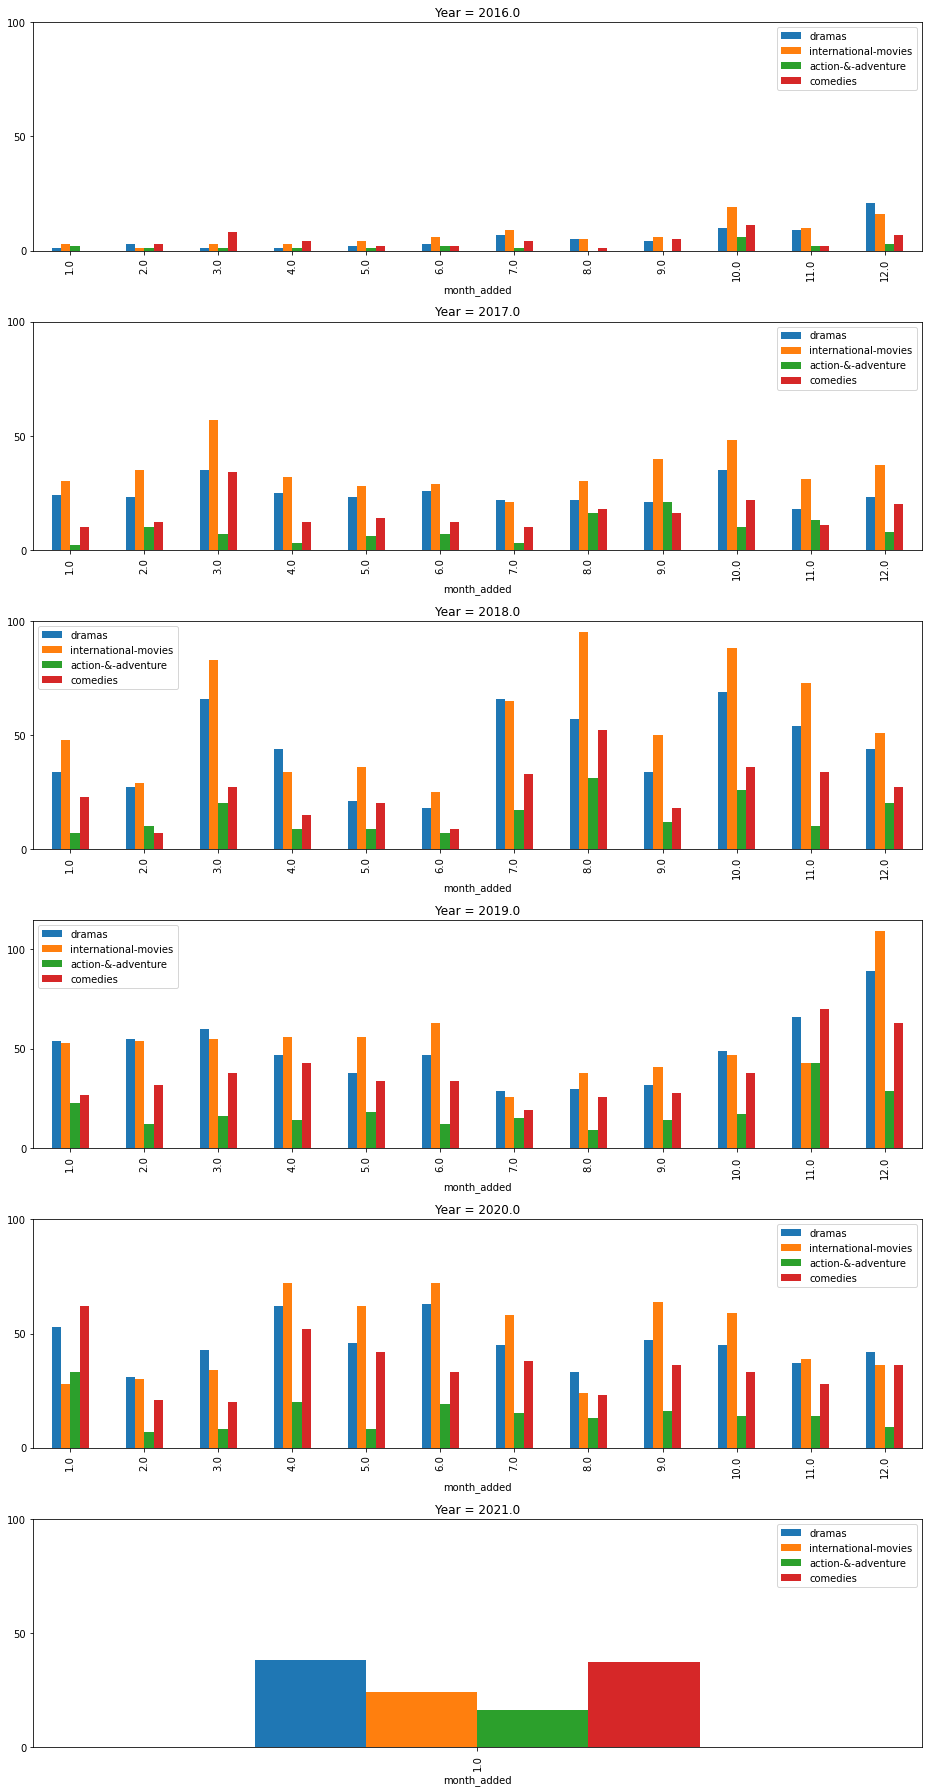

In [27]:
years = [year for year, month in movies_groupped.index.values]
years = np.unique(years)
fig, axes = plt.subplots(len(years), figsize=(13,25))
for year, ax in zip(years, axes.flat):
    movies_groupped.loc[year].plot(kind="bar", ax=ax)
    ax.set_title("Year = " + str(year))
    ax.set_yticks([0, 50, 100])
plt.tight_layout()

As we can see in the charts above, it not appear to be a specific relation between the month and the type that Netflix add to their catalogous, but we can notice the differents trending according the time.
For example, in december of 2019 were added aprox 100 international movies, but in september of the same year, just were added aprox 25 international movies. With this kind of data, and with other approach, we can analyze why this trends happen. Maybe because previous movies were succesfully recived by the public and they decided to add more of this type of movie. But it is out of the scope of this notebook.

Now, we are gonna consider the release year, to watch the old of movies that were added to netflix

Let's see which is the oldest movie and the newest one

In [28]:
min_year = df_movies["release_year"].min()
max_year = df_movies["release_year"].max()

print("The oldest movie added has a release year in = " + str(min_year))
print("And the newest one in = " + str(max_year))

The oldest movie added has a release year in = 1942
And the newest one in = 2021


From 1942 to 2021 there are 79 years, so we are gonna create bins of a range of 8 years

In [29]:
bin_range = 8
bins = [i for i in range(min_year, max_year, bin_range)] + [max_year]
df_movies["release_year_bin"] = pd.cut(df_movies["release_year"], bins=bins)
df_movies["release_year_bin"] = df_movies["release_year_bin"].astype(str)
df_movies.drop(df_movies[df_movies["release_year_bin"] == "nan"].index, inplace=True)
df_movies.reset_index(drop=True, inplace=True)
df_movies.head()

,type,rating,duration,date_added,release_year,year_added,month_added,international-tv-shows,dramas,international-movies,action-&-adventure,comedies,duration_min,month_addedx,release_year_bin
0,Movie,TV-MA,93 min,2016-12-23,2016,2016.0,12.0,0,1,1,0,0,93,December,"(2014.0, 2021.0]"
1,Movie,R,78 min,2018-12-20,2011,2018.0,12.0,0,0,1,0,0,78,December,"(2006.0, 2014.0]"
2,Movie,PG-13,80 min,2017-11-16,2009,2017.0,11.0,0,0,0,1,0,80,November,"(2006.0, 2014.0]"
3,Movie,PG-13,123 min,2020-01-01,2008,2020.0,1.0,0,1,0,0,0,123,January,"(2006.0, 2014.0]"
4,Movie,TV-MA,95 min,2020-06-01,2019,2020.0,6.0,0,0,1,0,0,95,June,"(2014.0, 2021.0]"


In [30]:
cols_to_use = ["year_added", "release_year_bin", "dramas", "international-movies", "action-&-adventure", "comedies"]
movies_groupped_by_release_year = df_movies[df_movies["year_added"]>=2016][cols_to_use].groupby(["year_added", "release_year_bin"]).sum().dropna()
movies_groupped_by_release_year["total_movies"] = movies_groupped_by_release_year.apply(lambda x: sum(x.values), axis=1)
movies_groupped_by_release_year

dramas  international-movies  action-&-adventure  \
year_added release_year_bin                                                     
2016.0     (1966.0, 1974.0]       0                     1                   1   
           (1974.0, 1982.0]       1                     0                   0   
           (1990.0, 1998.0]       2                     0                   0   
           (1998.0, 2006.0]       0                     2                   0   
           (2006.0, 2014.0]      12                    21                   7   
           (2014.0, 2021.0]      52                    61                  12   
2017.0     (1942.0, 1950.0]       0                     0                   0   
           (1958.0, 1966.0]       4                     4                   0   
           (1966.0, 1974.0]       2                     5                   2   
           (1974.0, 1982.0]       2                     4                   2   
           (1982.0, 1990.0]       3                     5                   3   
           (1990.0, 1998.0]      12                    12                   1   
           (1998.0, 2006.0]      11                    18                  10   
           (2006.0, 2014.0]      52                    95                  18   
           (2014.0, 2021.0]     211                   275                  70   
2018.0     (1974.0, 1982.0]       1                     8                   8   
           (1982.0, 1990.0]       6                    16                   9   
           (1990.0, 1998.0]      15                    18                  11   
           (1998.0, 2006.0]      47                    53                  17   
           (2006.0, 2014.0]     139                   193                  40   
           (2014.0, 2021.0]     326                   389                  93   
2019.0     (1950.0, 1958.0]       2                     0                   1   
           (1958.0, 1966.0]       7                     2                   3   
           (1966.0, 1974.0]      10                     7                   3   
           (1974.0, 1982.0]      16                    11                  11   
           (1982.0, 1990.0]      13                     8                   6   
           (1990.0, 1998.0]      16                     7                  16   
           (1998.0, 2006.0]      44                    42                  37   
           (2006.0, 2014.0]     133                   132                  53   
           (2014.0, 2021.0]     355                   432                  92   
2020.0     (1950.0, 1958.0]       3                     3                   0   
           (1958.0, 1966.0]       1                     0                   1   
           (1966.0, 1974.0]       5                     2                   0   
           (1974.0, 1982.0]      11                    14                   3   
           (1982.0, 1990.0]      11                     7                   6   
           (1990.0, 1998.0]      16                     9                   8   
           (1998.0, 2006.0]      35                    37                  15   
           (2006.0, 2014.0]      91                   102                  46   
           (2014.0, 2021.0]     374                   404                  97   
2021.0     (1966.0, 1974.0]       2                     0                   2   
           (1982.0, 1990.0]       2                     0                   0   
           (1990.0, 1998.0]       3                     0                   1   
           (1998.0, 2006.0]       5                     6                   3   
           (2006.0, 2014.0]      14                     7                   7   
           (2014.0, 2021.0]      12                    11                   3   

                             comedies  total_movies  
year_added release_year_bin                          
2016.0     (1966.0, 1974.0]         0             2  
           (1974.0, 1982.0]         0             1  
     

In [86]:
def plot_piechart(year):
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(aspect="equal"))
    data = movies_groupped_by_release_year.loc[year]["total_movies"]
    labels = movies_groupped_by_release_year.loc[year].index.values
    colors = ["#454ADE", "#1B1F3B", "#B14AED", "#C874D9", "#E1BBC9", "#586A6A", "#A07178", "#519872", "#F5D547"]

    explode = [0.05]*len(labels)
    wedges, texts, autotexts = ax.pie(data, autopct="%.1f%%", explode=explode, colors=colors)
    ax.legend(wedges, labels,
              title="Range of years",
              loc="center left",
              bbox_to_anchor=(1, 0, 0.5, 1))

    plt.setp(autotexts, size=8, weight="bold")

    plt.title("Release year of the movies added in " + str(int(year)), fontsize=20)
    plt.show()

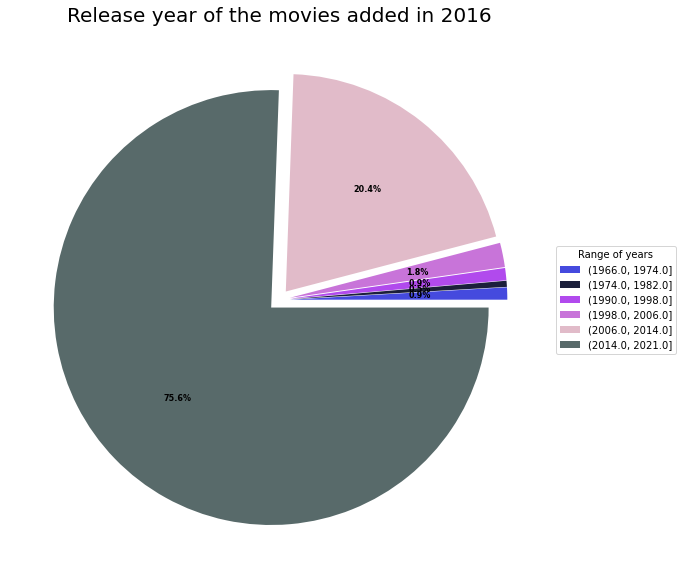

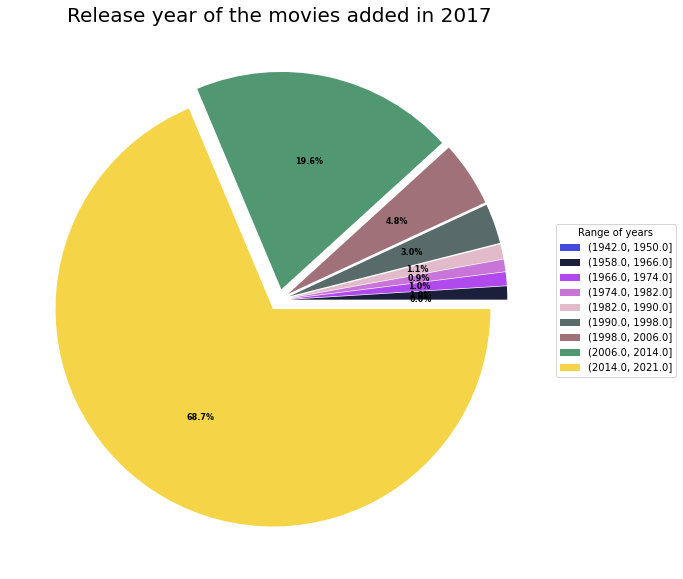

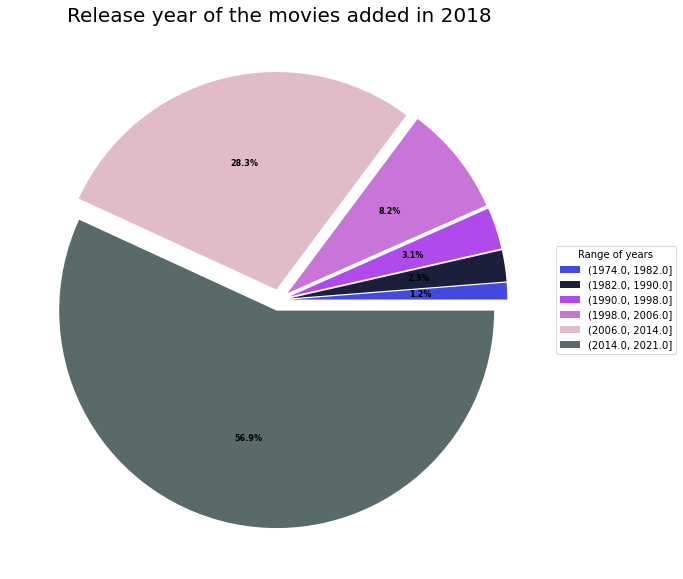

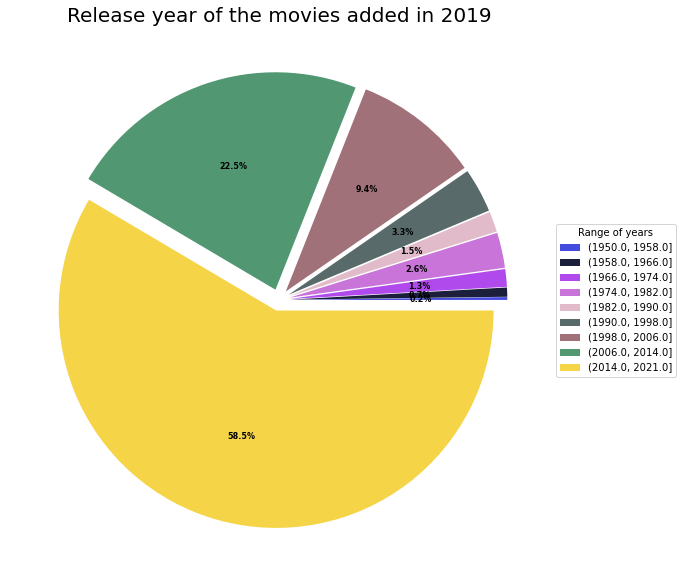

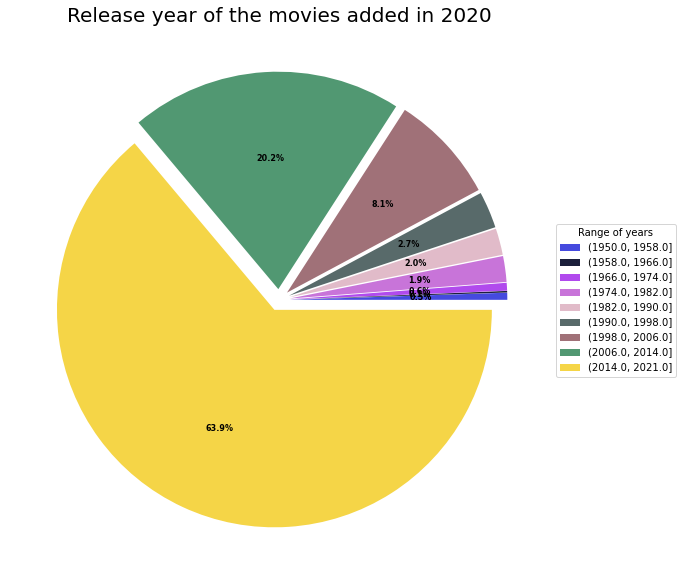

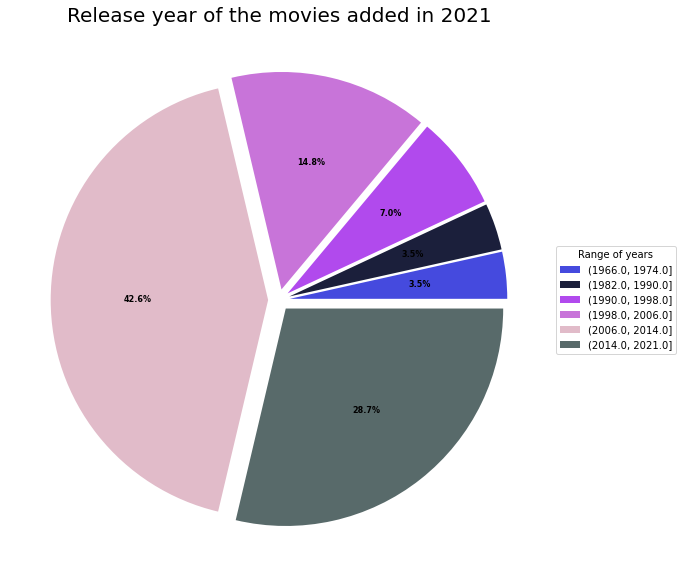

In [88]:
for i in years:
    plot_piechart(i)



[//]: # "Cell intentionally left in blank"

